# Homework 5: TD Learning

In this assignment you will implement Sarsa, Expected Sarsa, and Q-Learning and test these algorithms on the Frozen-lake environment and a Cartpole environment with a discrete state space.

In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import copy
from collections import defaultdict

from gym.envs.toy_text.frozen_lake import FrozenLakeEnv
from gym.envs.classic_control.cartpole import CartPoleEnv

plt.style.use('ggplot')

### $\epsilon$-Greedy Decay

A fairly typical thing to do when using a $\epsilon$-greedy exploration strategy is to anneal $\epsilon$ from its starting value to some final value over a number of timesteps. This allows your agent to explore the environemnt more at the beginning of training when it knows very little about the environemnt and then explore less as its policy becomes more and more optimal. For the CartPole environment I reccomend the final $\epsilon$ be set at 0.1 and for the frozen lake environment I reccomend the final $\epsilon$ be set to 0.0. Feel free to play around with these parameters however as your results might be a bit different than mine.

In [2]:
class LinearSchedule(object):                                                                                                                                                                                                                                           
    def __init__(self, schedule_timesteps, final_p, initial_p=1.0):                                                                                                                                                                                                     
        '''
        Linear interpolation between initial_p and final_p over                                                                                                                                                                                                      
        schedule_timesteps. After this many timesteps pass final_p is                                                                                                                                                                                                   
        returned.                                                                                                                                                                                                                                                       
                                                                                                                                                                                                                                                                        
        Args:                                                                                                                                                                                                                                                    
            - schedule_timesteps: Number of timesteps for which to linearly anneal initial_p to final_p                                                                                                                                                                                                                                                  
            - initial_p: initial output value                                                                                                                                                                                                                                        
            -final_p: final output value                                                                                                                                                                                                                                          
        '''                                                                                                                                                                                                                                                       
        self.schedule_timesteps = schedule_timesteps                                                                                                                                                                                                                    
        self.final_p = final_p                                                                                                                                                                                                                                          
        self.initial_p = initial_p                                                                                                                                                                                                                                      
                                                                                                                                                                                                                                                                         
    def value(self, t):                                                                                                                                                                                                                                                 
        fraction = min(float(t) / self.schedule_timesteps, 1.0)                                                                                                                                                                                                         
        return self.initial_p + fraction * (self.final_p - self.initial_p) 

### Discrete Cart Pole

In order to train a tabular agent, such as Sarsa or Q-learning, on a environment with a continuous state space, we need to first discretize the state space. Generally, the finer the discretization the more optimal your policy will be but the longer it will take to train.

For additional info on the Cart-pole problem see [here](https://github.com/openai/gym/wiki/CartPole-v0).

In [3]:
class DiscreteCartPole(object):
    def __init__(self):
        self.env = CartPoleEnv()
        self.action_space = self.env.action_space
        self.round = 1
        
    def reset(self):
        obs = self.env.reset()
        return tuple(np.around(obs, self.round).tolist())
    
    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        return tuple(np.around(obs, self.round).tolist()), reward, done, info

In [5]:
frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=False)
slippery_frozen_lake_env = FrozenLakeEnv(desc=None, map_name="4x4",is_slippery=True)
cart_pole_env = DiscreteCartPole()

In [115]:
def eGreedyActionSelection(q_curr, eps):
    action_prob=[eps/float(len(q_curr))]*len(q_curr)
    for index in np.where(q_curr==np.max(q_curr))[0]:
        action_prob[index]+=(1.0-eps)/float(np.sum(q_curr==np.max(q_curr)))
    if(np.random.random()>eps):
        if(np.sum(q_curr==np.max(q_curr))>1):
            action=np.where(q_curr==np.max(q_curr))[0][np.random.randint(np.sum(q_curr==np.max(q_curr)))]
        else:
            action=np.where(q_curr==np.max(q_curr))[0][0]
    else:
        action=np.random.randint(len(q_curr))
    return action,action_prob
    '''
    Preforms epsilon greedy action selectoin based on the Q-values.
    
    Args:
        q_curr: A numpy array that contains the Q-values for each action for a state.
        eps: The probability to select a random action. Float between 0 and 1.
        
    Returns:
        The selected action.
    '''

In [196]:
def sarsa(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200):
    '''
    Sarsa algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)    
    for i_episode in range(num_episodes):
        state = env.reset()
        done=False
        t=0
        while t<max_episode_steps and not done:
            eps=exploration.value(t)
            action,action_prob =  eGreedyActionSelection(Q[state], eps)
            next_state, reward, done, _ = env.step(action)
            # Pick the next action
            next_action,next_action_prob =  eGreedyActionSelection(Q[next_state], eps)
            # Update statistics
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            # TD Update
            td_target = reward + gamma * Q[next_state][next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            action = next_action
            state = next_state    
            t+=1
#         print episode_rewards[i_episode]

    
    
    return Q, episode_rewards, episode_lengths

#### Test your implentation on the Frozen-lake (both slippery and not slippery) environment and the discrete Cart-pole environment. You should plot the episode rewards over time averaged over 50 training runs. It might be helpful to smooth this curve over a time window of 100 episodes in order to get  a more clear picture of the learning process. 

In [197]:
def list_add(a,b):
    c = []
    for i in range(len(a)):
        c.append(a[i]+b[i])
    return c

In [198]:
def plotLearningCurve(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=sarsa(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(500):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,500+1))
    rewards_avg_plot= np.array(rewards_avg[0:500])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



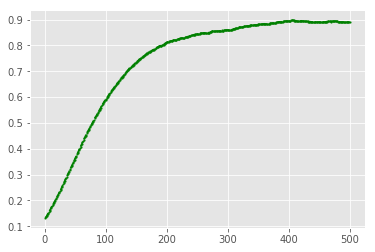

In [166]:
plotLearningCurve(frozen_lake_env,  3000)
# plotLearningCurve(slippery_frozen_lake_env,  6000)
# plotLearningCurve(cart_pole_env,  3000)

In [167]:
def plotLearningCurve2(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=sarsa(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(5000):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,5000+1))
    rewards_avg_plot= np.array(rewards_avg[0:5000])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



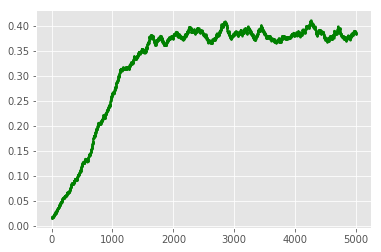

In [169]:
plotLearningCurve2(slippery_frozen_lake_env,  6000)

In [170]:
def plotLearningCurve3(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=sarsa(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=50)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(15000):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,15000+1))
    rewards_avg_plot= np.array(rewards_avg[0:15000])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



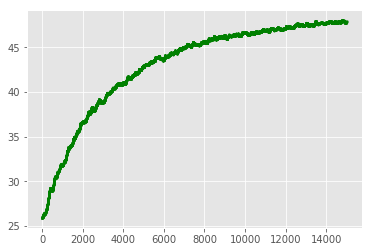

In [171]:
plotLearningCurve3(cart_pole_env,  16000)

### Exercise 2 (10 Points):

Implement the on-policy TD control algorithm known as expected SARSA. You should find the optimal $\epsilon$-greedy policy.

In [172]:
def expected_sarsa(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200):
    '''
    Q-learning algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)
    for i_episode in range(num_episodes):
        state = env.reset()
        done=False
        t=0
        while t<max_episode_steps and not done:
            eps=exploration.value(t)
            action,action_prob =  eGreedyActionSelection(Q[state], eps)
            next_state, reward, done, _ = env.step(action)
            # Pick the next action
            next_action,next_action_prob =  eGreedyActionSelection(Q[next_state], eps)
            # Update statistics
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            # TD Update
            td_target = reward + gamma * np.dot(Q[next_state],next_action_prob)/env.action_space.n
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            action = next_action
            state = next_state    
            t+=1
#         print episode_rewards[i_episode]

    
    
    return Q, episode_rewards, episode_lengths

#### Test your implentation on the Frozen-lake (both slippery and not slippery) environment and the discrete Cart-pole environment. You should plot the episode rewards over time averaged over 50 training runs.  It might be helpful to smooth this curve over a time window of 100 episodes in order to get  a more clear picture of the learning process.

In [173]:
def plotLearningCurve_EXP(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=expected_sarsa(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(500):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,500+1))
    rewards_avg_plot= np.array(rewards_avg[0:500])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



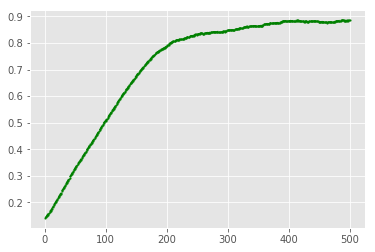

In [174]:
plotLearningCurve_EXP(frozen_lake_env,  3000)

In [175]:
def plotLearningCurve_EXP2(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=expected_sarsa(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(5000):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,5000+1))
    rewards_avg_plot= np.array(rewards_avg[0:5000])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



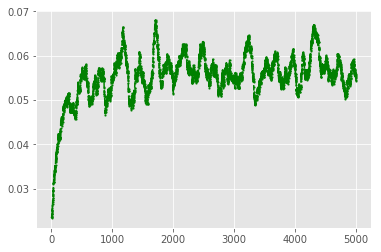

In [176]:
plotLearningCurve_EXP2(slippery_frozen_lake_env,6000)

In [177]:
def plotLearningCurve_EXP3(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=expected_sarsa(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=50)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(15000):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,15000+1))
    rewards_avg_plot= np.array(rewards_avg[0:15000])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



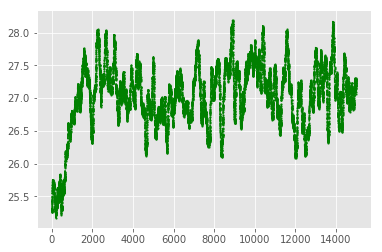

In [178]:
 plotLearningCurve_EXP3(cart_pole_env, 16000)

### Exercise 3 (10 Points):

Implement the off-policy TD control algorithm known as Q-learning. You should find the optimal greedy policy while following an $\epsilon$-greedy policy.

In [201]:
def q_learning(env, num_episodes, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200):
    '''
    Q-learning algorithm.
    
    Args:
        - env: The environment to train the agent on
        - num_episodes: The number of episodes to train the agent for
        - gamma: The discount factor
        - alpha: The stepsize
        - start_eps: The initial epsilon value for e-greedy action selection
        - final_eps: The final epsilon value for the e-greedy action selection
        - annealing_steps: The number of steps to anneal epsilon over
        - max_episode_steps: The maximum number of steps an episode can take
        
    Returns: (Q_func, episode_rewards, episode_lengths)
        - Q: Dictonary mapping state -> action values
        - episode_rewards: Numpy array containing the reward of each episode during training
        - episode_lengths: Numpy array containing the length of each episode during training
    '''
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    episode_rewards = np.zeros(num_episodes)
    episode_lengths = np.zeros(num_episodes)
    
    exploration = LinearSchedule(annealing_steps, start_eps, final_eps)    
    for i_episode in range(num_episodes):
        state = env.reset()
        done=False
        t=0
        while t<max_episode_steps and not done:
            eps=exploration.value(t)
            action,action_prob =  eGreedyActionSelection(Q[state], eps)
            next_state, reward, done, _ = env.step(action)
            # Pick the next action
            next_action,next_action_prob =  eGreedyActionSelection(Q[next_state], eps)
            # Update statistics
            episode_rewards[i_episode] += reward
            episode_lengths[i_episode] = t
            # TD Update
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][ best_next_action]
            td_delta = td_target - Q[state][action]
            Q[state][action] += alpha * td_delta
            action = next_action
            state = next_state     
            t+=1
#         print episode_rewards[i_episode]

    
    
    return Q, episode_rewards, episode_lengths

#### Test your implentation on the Frozen-lake (both slippery and not slippery) environment and the discrete Cart-pole environment. You should plot the episode rewards over time averaged over 50 training runs. It might be helpful to smooth this curve over a time window of 100 episodes in order to get  a more clear picture of the learning process.

In [202]:
def plotLearningCurve_Q(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=q_learning(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(500):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,500+1))
    rewards_avg_plot= np.array(rewards_avg[0:500])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')



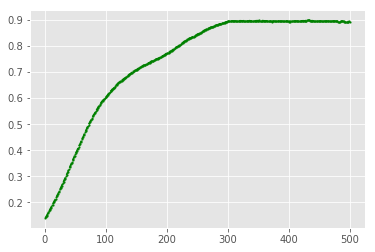

In [203]:
plotLearningCurve_Q(frozen_lake_env,  3000)

In [204]:
def plotLearningCurve_Q2(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=q_learning(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=200)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(5000):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,5000+1))
    rewards_avg_plot= np.array(rewards_avg[0:5000])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')


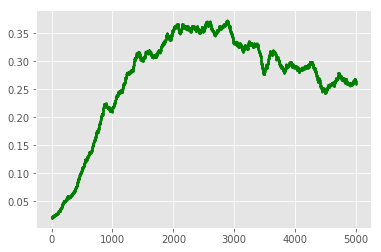

In [206]:
plotLearningCurve_Q2(slippery_frozen_lake_env,6000)

In [207]:
def plotLearningCurve_Q3(env,  episode_numbers):
    rewards_iter=[0 for _ in range(episode_numbers)]
    for run_numbers in range(0,50):
        Q_func,episode_rewards,episode_lengths=q_learning(env, episode_numbers, gamma=1.0, alpha=0.1, 
                start_eps=0.2, final_eps=0.1, annealing_steps=1000,
                max_episode_steps=50)
        rewards=episode_rewards
        stored_reward=rewards[0]
        for episode_num in range(15000):
            rewards[episode_num]=sum(rewards[episode_num:episode_num+100])/100
#             print rewards[episode_num]
        rewards_iter=list_add(rewards_iter, rewards)
    rewards_avg = [c/50 for c in rewards_iter]
    episode_num_plot= np.array(range(1,15000+1))
    rewards_avg_plot= np.array(rewards_avg[0:15000])
    plt.plot(episode_num_plot,rewards_avg_plot,color='green',linestyle='--',marker='s',markersize=1,label='learning curve')


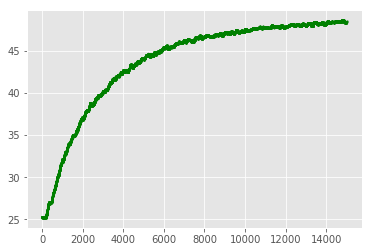

In [208]:
 plotLearningCurve_Q3(cart_pole_env, 16000)